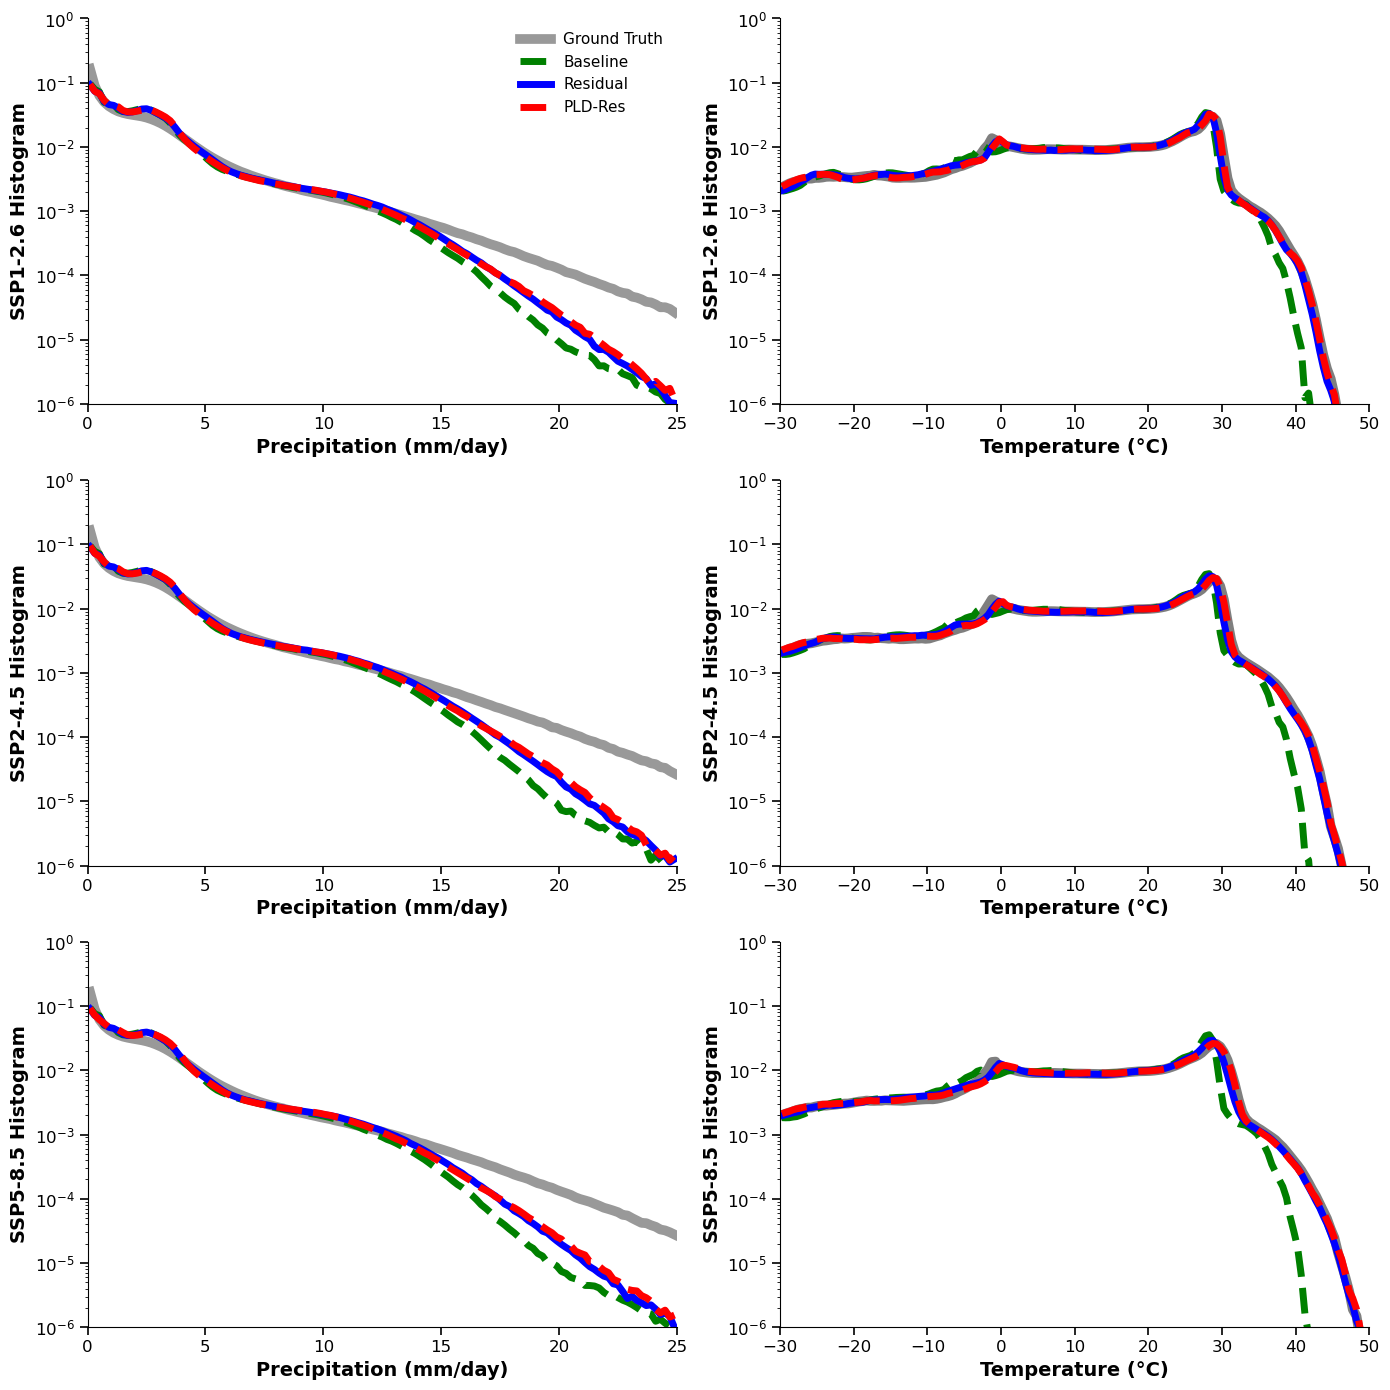

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path

# Configuration
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

# SSP scenarios only
scenarios = ['ssp126', 'ssp245', 'ssp585']
scenario_labels = {
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Models to compare 
models = {
    'groundtruth': 'Ground Truth',
    'baseline': 'Baseline',
    'raw_residual': 'Residual',
    'pld_residual': 'PLD-Res'
}

# Colors for each model
model_colors = {
    'groundtruth': 'black',
    'baseline': 'green',     
    'raw_residual': 'blue',  
    'pld_residual': 'red'   
}

# Line styles
model_linestyles = {
    'groundtruth': '-',
    'baseline': '--',
    'raw_residual': '-',
    'pld_residual': '--'
}

# Line widths
model_linewidths = {
    'groundtruth': 7.0,
    'baseline': 5.0,
    'raw_residual': 5.0,
    'pld_residual': 5.0
}

def compute_histogram_density(data, bins):
    """Compute normalized histogram density for given data and bins"""
    data_flat = data.flatten()
    data_flat = data_flat[~np.isnan(data_flat)]
    
    # Compute histogram with density normalization
    counts, _ = np.histogram(data_flat, bins=bins, density=False)
    
    # Normalize to get probability density
    total = counts.sum()
    if total > 0:
        density = counts / total
    else:
        density = counts
    
    return density


def plot_precipitation_and_temperature_histograms():
    """Create histogram comparison plot for precipitation and temperature"""
    
    # Create figure with 3x2 subplots
    fig, axes = plt.subplots(3, 2, figsize=(14, 14))
    
    # Define bins for histograms
    pr_bins = np.linspace(0, 25, 126)  # 0 to 25 mm/day for precipitation
    pr_bin_centers = (pr_bins[:-1] + pr_bins[1:]) / 2
    
    tas_bins = np.linspace(-30, 50, 161)  # -30 to 50 °C for temperature
    tas_bin_centers = (tas_bins[:-1] + tas_bins[1:]) / 2
    
    # Process each SSP scenario
    for row, scenario in enumerate(scenarios):
        
        # ===== Load Precipitation Data =====
        pr_data = {}
        
        # Load ground truth
        pr_gt_file = results_dir / f"pr_evaluation_{scenario}.nc"
        if pr_gt_file.exists():
            ds_pr_gt = xr.open_dataset(pr_gt_file)
            pr_data['groundtruth'] = ds_pr_gt['groundtruth'].values
            
            # Load baseline model predictions
            if 'pred_zscore_pixel' in ds_pr_gt:
                pr_data['baseline'] = ds_pr_gt['pred_zscore_pixel'].values
        
        # Load residual model predictions for pr
        pr_residual_file = results_residual_dir / f"pr_evaluation_{scenario}.nc"
        if pr_residual_file.exists():
            ds_pr_residual = xr.open_dataset(pr_residual_file)
            
            model_map = {
                'raw_residual': 'pred_raw',
                'pld_residual': 'pred_grid'
            }
            
            for model_key, data_key in model_map.items():
                if data_key in ds_pr_residual:
                    pr_data[model_key] = ds_pr_residual[data_key].values
        
        # ===== Load Temperature Data =====
        tas_data = {}
        
        # Load ground truth
        tas_gt_file = results_dir / f"tas_evaluation_{scenario}.nc"
        if tas_gt_file.exists():
            ds_tas_gt = xr.open_dataset(tas_gt_file)
            tas_data['groundtruth'] = ds_tas_gt['groundtruth'].values
            
            # Load baseline model predictions
            if 'pred_zscore_pixel' in ds_tas_gt:
                tas_data['baseline'] = ds_tas_gt['pred_zscore_pixel'].values
        
        # Load residual model predictions for tas
        tas_residual_file = results_residual_dir / f"tas_evaluation_{scenario}.nc"
        if tas_residual_file.exists():
            ds_tas_residual = xr.open_dataset(tas_residual_file)
            
            for model_key, data_key in model_map.items():
                if data_key in ds_tas_residual:
                    tas_data[model_key] = ds_tas_residual[data_key].values
        
        # ===== Plot Precipitation Histogram (column 0) =====
        ax_pr = axes[row, 0]
        
        for model_key in models.keys():
            if model_key in pr_data:
                data = pr_data[model_key]
                
                # Compute normalized histogram density
                density = compute_histogram_density(data, pr_bins)
                
                # Filter out zeros for log scale
                mask = density > 0
                
                # Plot as line
                ax_pr.plot(pr_bin_centers[mask], density[mask], 
                          color=model_colors[model_key],
                          linestyle=model_linestyles[model_key],
                          linewidth=model_linewidths[model_key],
                          label=models[model_key],
                          alpha=0.4 if model_key == 'groundtruth' else 1.0)
        
        # Format precipitation histogram axis
        ax_pr.set_yscale('log')
        ax_pr.set_xlim(0, 25)
        ax_pr.set_ylim(1e-6, 1)
        ax_pr.set_xlabel('Precipitation (mm/day)', fontsize=14, fontweight='bold')
        ax_pr.set_ylabel(f'{scenario_labels[scenario]} Histogram', fontsize=14, fontweight='bold')
        ax_pr.tick_params(labelsize=12, length=6, width=1.2)
        ax_pr.spines['top'].set_visible(False)
        ax_pr.spines['right'].set_visible(False)
        
        # Add legend to first panel
        if row == 0:
            ax_pr.legend(loc='best', fontsize=11, frameon=False)
        
        # ===== Plot Temperature Histogram (column 1) =====
        ax_tas = axes[row, 1]
        
        for model_key in models.keys():
            if model_key in tas_data:
                data = tas_data[model_key]
                
                # Compute normalized histogram density
                density = compute_histogram_density(data, tas_bins)
                
                # Filter out zeros for log scale
                mask = density > 0
                
                # Plot as line
                ax_tas.plot(tas_bin_centers[mask], density[mask], 
                           color=model_colors[model_key],
                           linestyle=model_linestyles[model_key],
                           linewidth=model_linewidths[model_key],
                           label=models[model_key],
                           alpha=0.5 if model_key == 'groundtruth' else 1.0)
        
        # Format temperature histogram axis
        ax_tas.set_yscale('log')
        ax_tas.set_xlim(-30, 50)
        ax_tas.set_ylim(1e-6, 1)
        ax_tas.set_xlabel('Temperature (°C)', fontsize=14, fontweight='bold')
        ax_tas.set_ylabel(f'{scenario_labels[scenario]} Histogram', fontsize=14, fontweight='bold')
        ax_tas.tick_params(labelsize=12, length=6, width=1.2)
        ax_tas.spines['top'].set_visible(False)
        ax_tas.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    # Save figure
    output_file = figures_dir / "14_precipitation_temperature_histograms.png"
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()

# Create the plot
plot_precipitation_and_temperature_histograms()